In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, auc

c:\Users\nik20\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
c:\Users\nik20\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

In [2]:
"""
    _find_header_row(filename, search_terms=['Time', 's'])

read in excel file and check first ten rows for search terms. 
return the first row in which a search term appears.
if not found, return None.
"""
def _find_header_row(filename, search_terms=['Time', 's']):
    for i in range(10):  # Check first 10 rows
        df = pd.read_excel(filename, header=i, nrows=1)
        for search_term in search_terms:
            if search_term in df.columns:
                return i
    return None  # If header not found

"""
    read_data(cof, gas, carrier, ppm)

read in the sensor response data for a given COF exposed to a 
given gas with a given carrier at a given concentration.
returns list of pandas data frames with this data. (may be replicates)
each data frame has two columns: time, DeltaG/G0.

note: this is complicated because there are two formats for a given
cof, gas, carrier, ppm:
(1) multiple replicates in the same file
(2) multiple replicates in separate files
"""
def read_data(cof, gas, carrier, ppm):
    # get path to appropriate file
    path = Path.cwd().joinpath("Raw_sensing_data", gas, cof, carrier,).rglob("*.xlsx")

    # some folders contain multiple excel files, so create a list
    files = [file for file in path]
        
    # extract data from Excel files in list
    dfs = []
    for filename in files:
        # read in file (need to find header row; not consistent)
        header_row = _find_header_row(filename)
        df = pd.read_excel(filename, header=header_row)

        # chop time data for begin and end of exposure (check later)
        #    exposure time begins at 750s, ends 2580s later (3330s)
        #    only keep a subset of the cols (Time and (perhaps multiple) with deltaG/Go's)
        ids_cols_keep = df.columns.str.contains('Go', na=False) | (df.columns == 's') | (df.columns == 'Time')
        df = df.loc[1500:6660, df.columns[ids_cols_keep]]
        if 'Time' in df.columns:
            df = df.rename(columns={"Time": "s"})

        # check time is sliced properly
        assert df.iloc[0]["s"] == 750.0
        assert df.iloc[-1]["s"] == 3330.0
        # reshift time
        df["s"] = df["s"] - 750.0

        # drop columns with missing values
        df = df.dropna(axis='columns')

        df.reset_index(drop=True, inplace=True)

        # separate replicates into differente dataframes and append to dfs
        for i in df.columns:
            if 'G' in i and not np.all(df[i] == 100.0):
                data_rep = df[['s', i]]
                data_rep = data_rep.rename(columns={i: "ΔG/G0"})
                dfs.append(data_rep)
                 
    return dfs

In [3]:
data = read_data("Cu-COF-DC-8", "NH3", "N2_dry", 80)

In [4]:
_data = read_data("Cu-COF-DC-8", "H2S", "air_humid", 80)
_data[0]

,s,ΔG/G0
0,0.0,0.000000
1,0.5,0.000000
2,1.0,-0.217382
3,1.5,0.000000
4,2.0,-0.217382
...,...,...
5156,2578.0,89.236542
5157,2578.5,89.247393
5158,2579.0,89.253904
5159,2579.5,89.228954


In [5]:
"""
    linear_regression(df, ids_split)
    
perform linear regression on df[ids_split]:
ΔG/G0 = m * t + b

# arguments:
* df := dataframe of a single partition of sensor_response data
* ids_split := indices of response data partition

# output: dict of:
* coef := coefficient from linear regression
* r2 := r2 score
* ids_split
"""
def linear_regression(df, ids_split):
    X = df.loc[ids_split, "s"].to_numpy().reshape(-1, 1)
    y = df.loc[ids_split, "ΔG/G0"].to_numpy()
    
    reg = LinearRegression().fit(X, y)
    
    r2 = reg.score(X, y)

    slope = reg.coef_[0]
    intercept = reg.intercept_

    return {'slope': slope, 'r2': r2, 'ids_split': ids_split, 'intercept': intercept}

In [6]:
linear_regression(data[0], np.array_split(data[0].index, 10)[0])

{'slope': 0.07190634226333138,
 'r2': 0.9074217939352316,
 'ids_split': Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             507, 508, 509, 510, 511, 512, 513, 514, 515, 516],
            dtype='int64', length=517),
 'intercept': 33.1390039516367}

In [7]:
class SensorResponse:
    def __init__(self, cof, gas, carrier_gas, ppm, replicate_id):
        self.cof = cof
        self.gas = gas
        self.carrier_gas = carrier_gas
        self.ppm = ppm
        self.replicate_id = replicate_id

        try:
            self.data = read_data(cof, gas, carrier_gas, ppm)[replicate_id]
        except IndexError:
            print(f"Error: replicate_id {replicate_id} does not exist in the data.")

        # store features
        self.slope_info = None
        self.saturation = None
        self.auc = None
        
    """
    compute_initial_slope(self, partition_size, total_time_window, mse_bound)
    estimate initial slope of data.

      arguments:
     * partition_size := size of the time window for partitions (ex: 30sec)
     * total_time_window := the total time after introduction of substance
     * considered to compute intial slope (ex: 1000s)
     * mse_bound := bound on acceptable mean squared error for initial slope linear regression
    """
    def compute_initial_slope(self, n_partitions=50, max_time=750.0, r2_bound=0.75):
        early_df = self.data[self.data["s"] < max_time]
        
        # partition data indices
        ids_splits = np.array_split(early_df.index, n_partitions)
        
        # create list of regression on each partition of data which satisfy the mean_squared error bound
        regression_data = [linear_regression(early_df, ids_split) for ids_split in ids_splits]
        # filter according to r2
        regression_data = list(filter(lambda res: res['r2'] > r2_bound, regression_data))
                
        if len(regression_data) == 0:
            raise Exception("Data has no initial slopes that satisfy r2 bound.")  
        
        # find index of max absolute value of linear regression coefficients
        id_initial_slope = np.argmax([np.abs(rd['slope']) for rd in regression_data])

        # return regression_data which contains the initial slope 
        self.slope_info = regression_data[id_initial_slope]
        return self.slope_info

    def compute_saturation(self, n_partitions=100):
        ids_splits = np.array_split(self.data.index, n_partitions)

        # get mean over partitions
        means = [np.mean(self.data.iloc[ids_split]['ΔG/G0']) for ids_split in ids_splits]

        id_max_magnitude = np.argmax(np.abs(means))
        
        self.saturation = means[id_max_magnitude]
        return self.saturation

    def compute_features(self, **kwargs):
        self.compute_saturation(**kwargs)
        self.compute_initial_slope(**kwargs)
        self.compute_area_under_response_curve(**kwargs)
        
    # compute area under curve for each GBx DeltaG/G0 using sklearn auc
    def compute_area_under_response_curve(self, k=0):
        self.auc = auc(self.data["s"], self.data['ΔG/G0'])
        return self.auc
    
    def viz(self, save=True): # viz the data along with the response features or function u fit to it.
        if self.slope_info == None or self.saturation == None:
            raise Exception("Compute feautres first.")
            
        fig, ax = plt.subplots()
        
        plt.xlabel("time [s]")
        plt.ylabel("$\Delta G/G_0$")

        # plot raw response data
        plt.scatter(self.data['s'], self.data['ΔG/G0'])

        ###
        #   viz features
        ###
        # saturation
        plt.axhline(self.saturation, linestyle='-', color="gray")
        
        # slope
        t_start = self.data.loc[self.slope_info["ids_split"][0], 's']
        t_end = self.data.loc[self.slope_info["ids_split"][-1], 's']
        plt.plot(
            [t_start, t_end], 
            self.slope_info["slope"] * np.array([t_start, t_end]) + self.slope_info["intercept"], 
            color='orange'
        )

        all_info = "{}_{}_{}_{}ppm_{}".format(self.cof, self.gas, self.carrier_gas, 
                                                     self.ppm, self.replicate_id)
        plt.title(all_info)
        # create inset axes & plot initial slope data on them
        # ins_ax = fig.add_axes([0.6,0.2,0.3,0.3])
        # ins_ax.scatter(self.data.loc[initial_slope[3], 's'], self.data.loc[initial_slope[3], 'ΔG/G0'])
        # ins_ax.plot(self.data.loc[initial_slope[3], 's'], initial_slope[2], color = 'orange')

        if save:
            plt.savefig("responses/featurized_{}.png".format(all_info), format="png")
        plt.show()
        
        
    # def vector_representation(self,docnum=0): # returns the vector characterizing the response.
    #     response = []
    #     response.append(self.compute_initial_slope(k=docnum)[0])
    #     response.append(self.compute_saturation(k=docnum))
    #     response.append(self.compute_area(k=docnum))
    #     return response

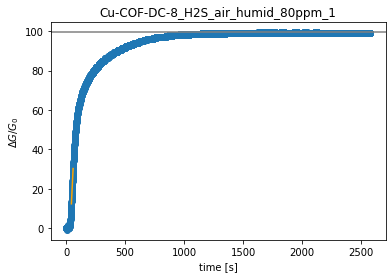

In [9]:
# Test the SensorResponse class initial_slope function
sensor_response = SensorResponse("Cu-COF-DC-8", "H2S", "air_humid", 80, 1)
sensor_response.compute_features()
# sensor_response.compute_initial_slope(r2_bound=0.95)
sensor_response.viz(save=True)

In [ ]:
sensor_response.compute_saturation()

99.40638770818612

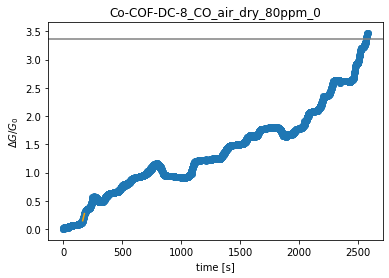

Error: replicate_id 1 does not exist in the data.


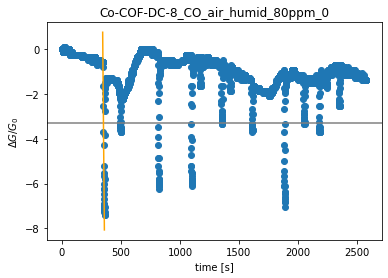

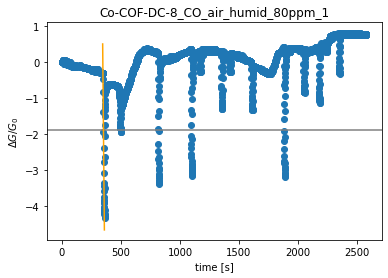

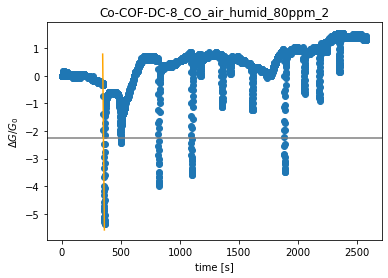

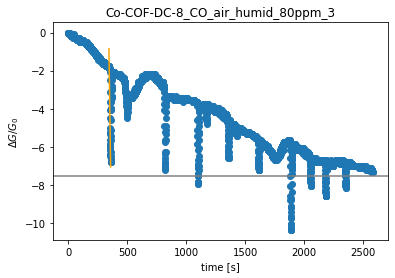

Error: replicate_id 4 does not exist in the data.


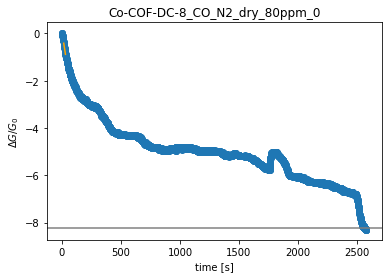

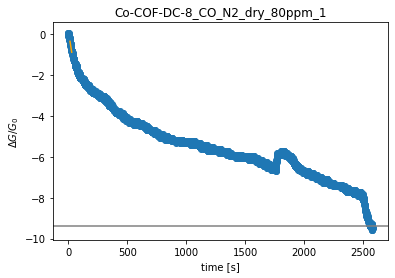

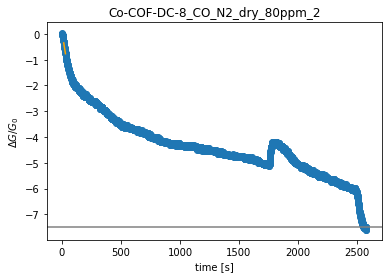

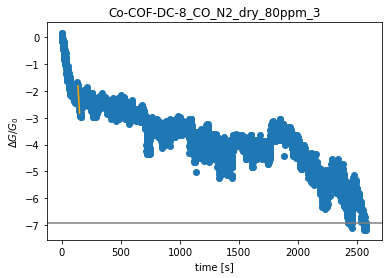

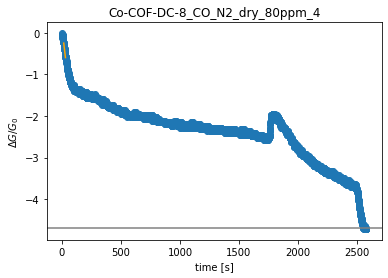

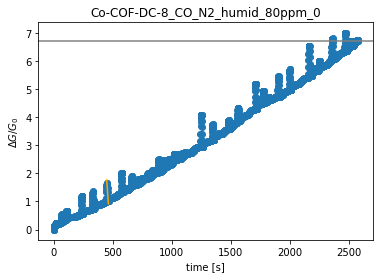

Error: replicate_id 1 does not exist in the data.
Error: replicate_id 0 does not exist in the data.
Error: replicate_id 0 does not exist in the data.
Error: replicate_id 0 does not exist in the data.
Error: replicate_id 0 does not exist in the data.


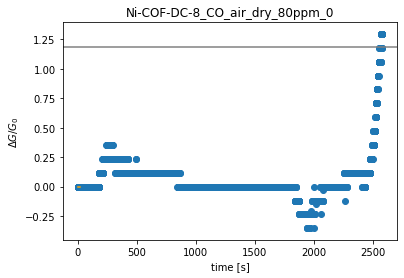

Error: replicate_id 1 does not exist in the data.
Error: replicate_id 0 does not exist in the data.


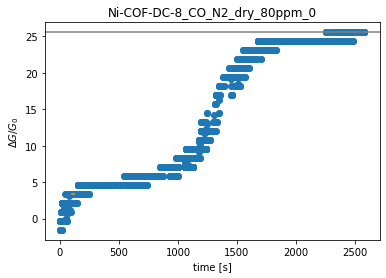

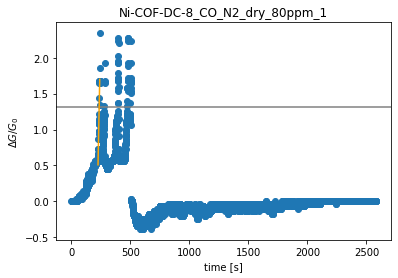

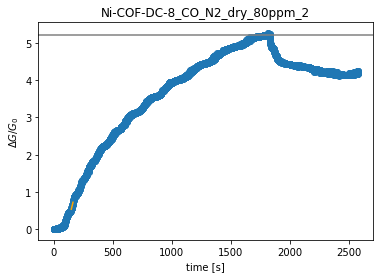

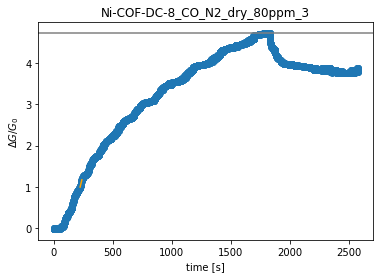

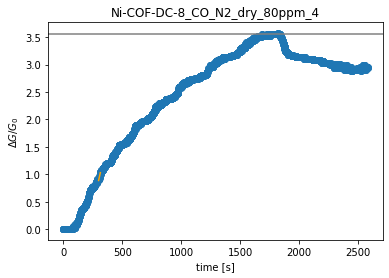

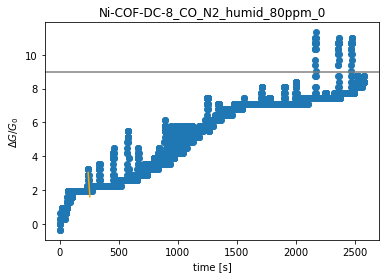

Error: replicate_id 1 does not exist in the data.


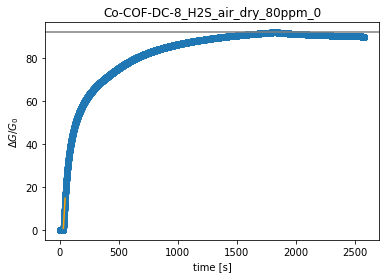

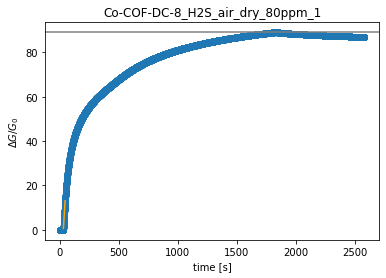

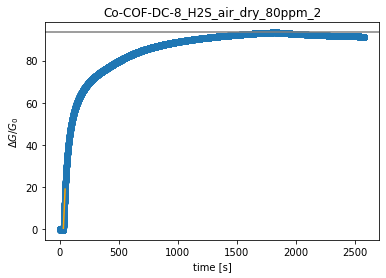

Error: replicate_id 3 does not exist in the data.


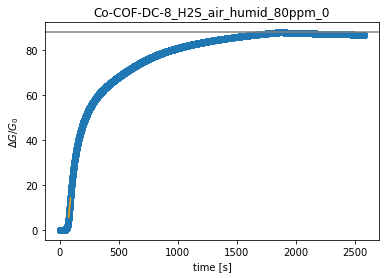

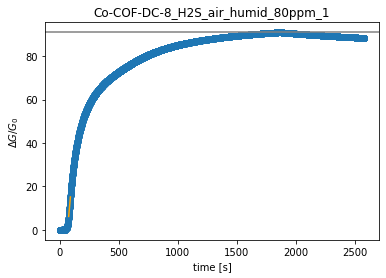

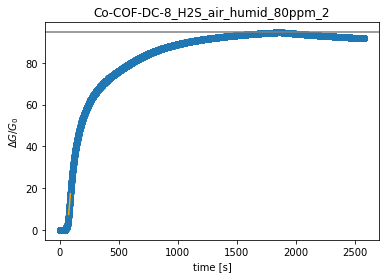

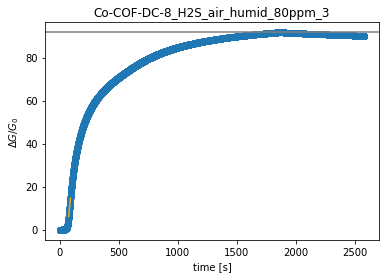

Error: replicate_id 4 does not exist in the data.


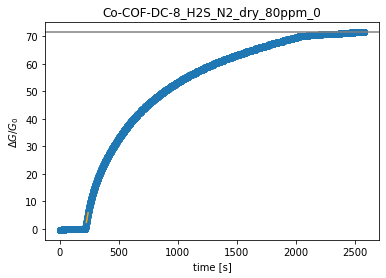

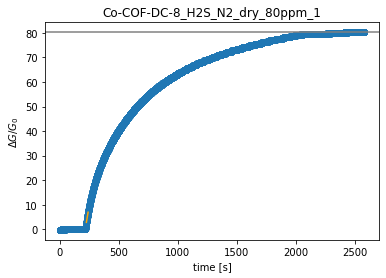

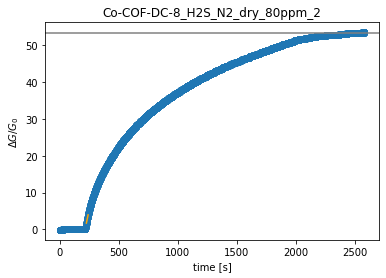

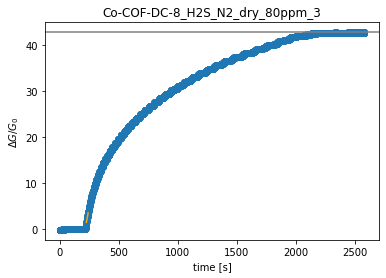

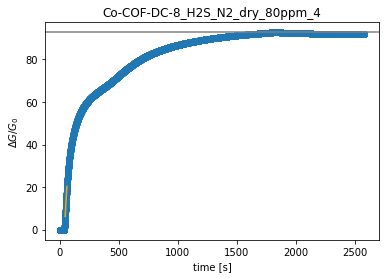

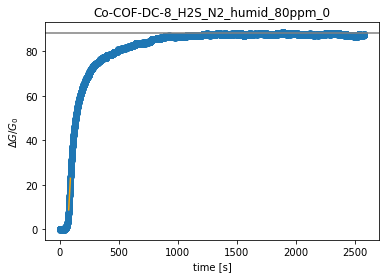

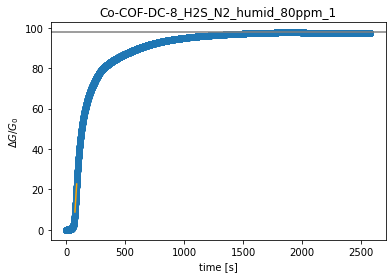

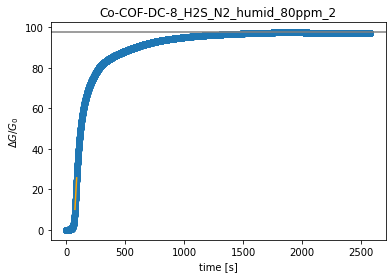

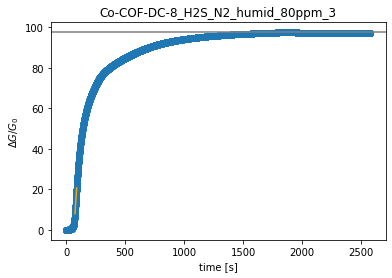

Error: replicate_id 4 does not exist in the data.


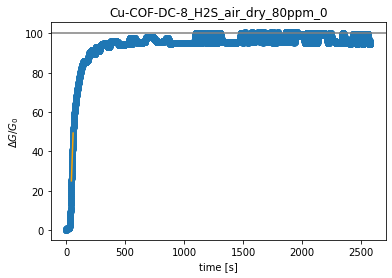

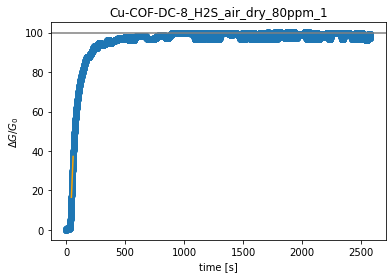

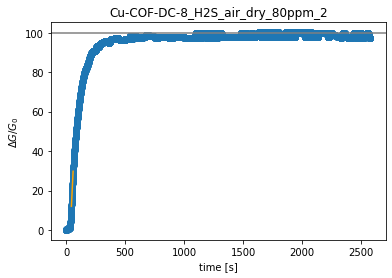

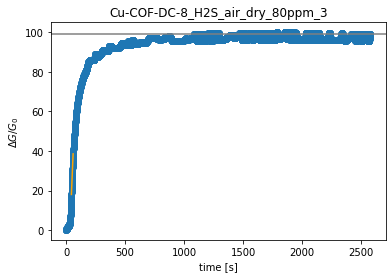

Error: replicate_id 4 does not exist in the data.


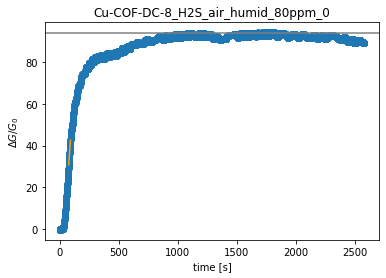

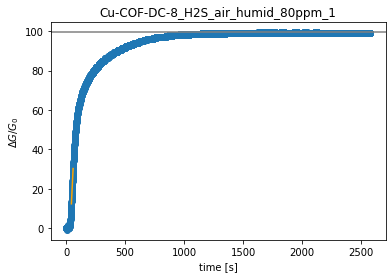

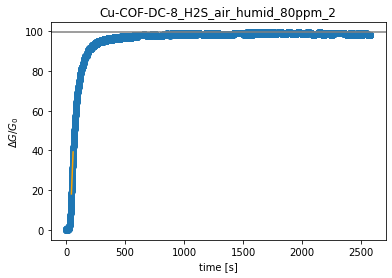

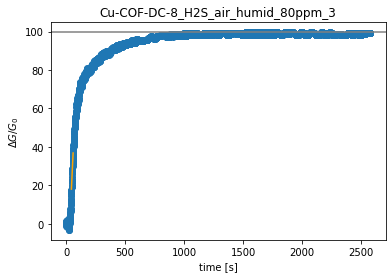

Error: replicate_id 4 does not exist in the data.


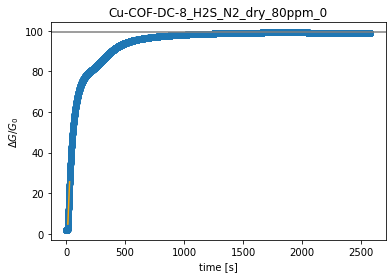

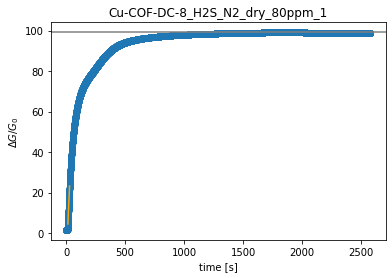

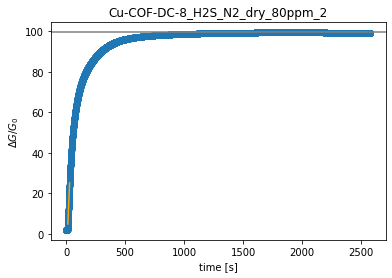

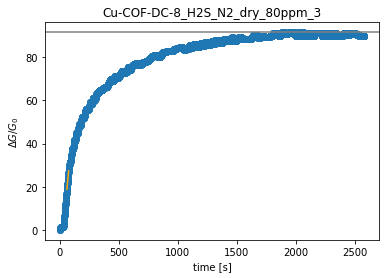

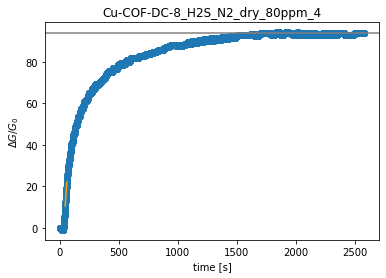

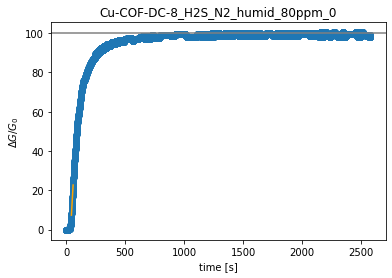

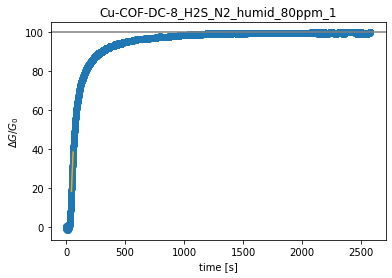

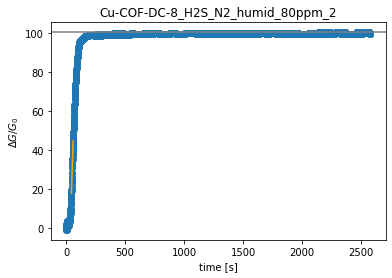

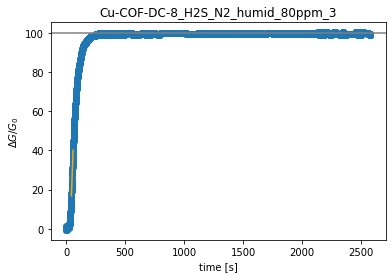

Error: replicate_id 4 does not exist in the data.
Error: replicate_id 0 does not exist in the data.
Error: replicate_id 0 does not exist in the data.


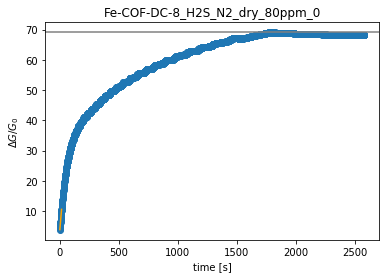

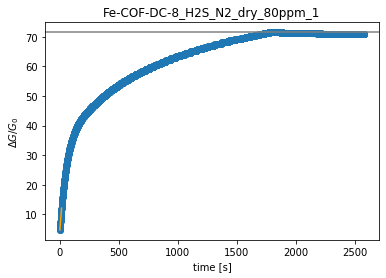

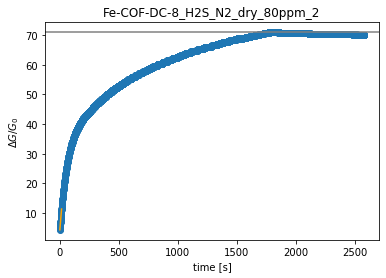

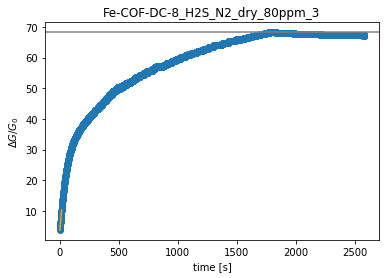

Error: replicate_id 4 does not exist in the data.
Error: replicate_id 0 does not exist in the data.


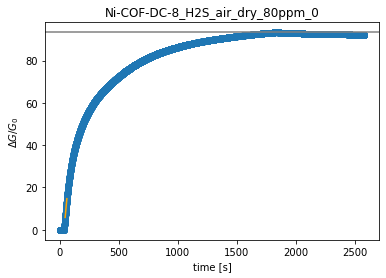

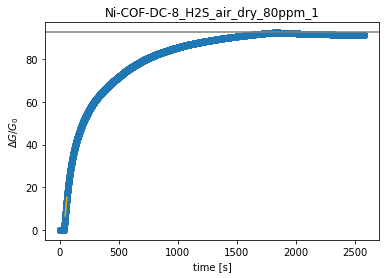

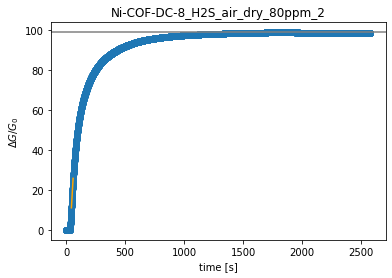

Error: replicate_id 3 does not exist in the data.


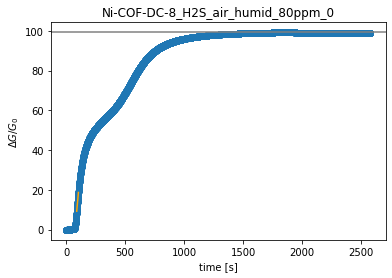

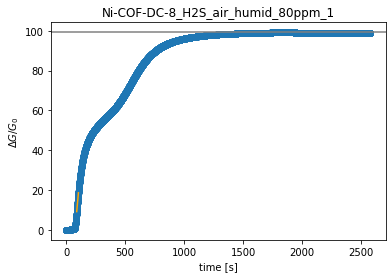

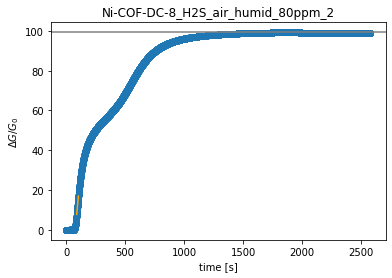

Error: replicate_id 3 does not exist in the data.


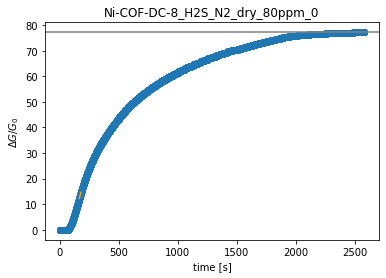

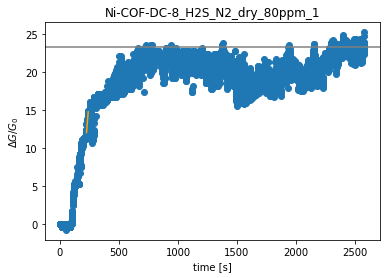

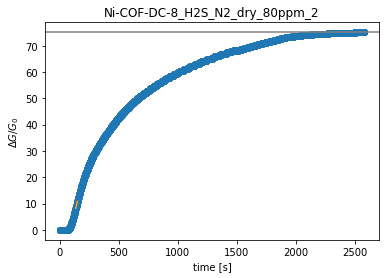

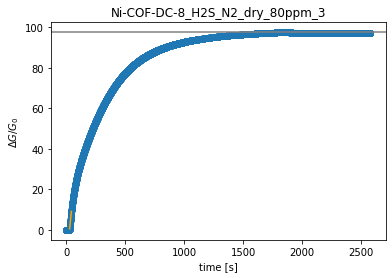

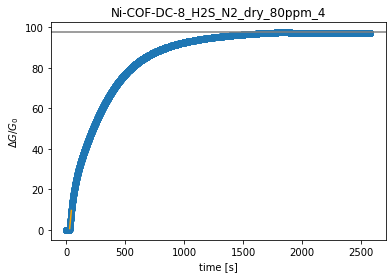

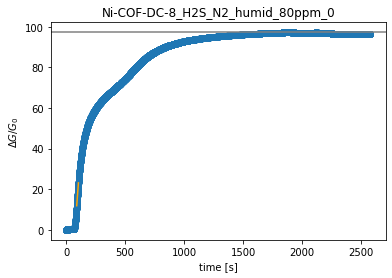

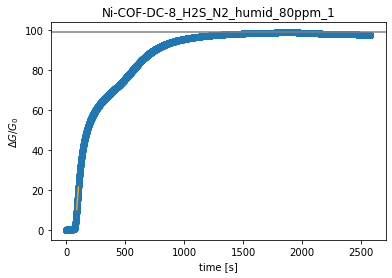

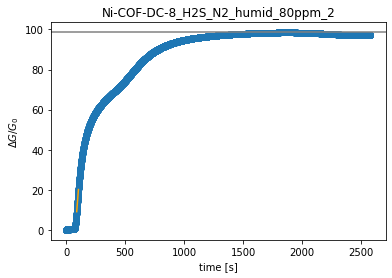

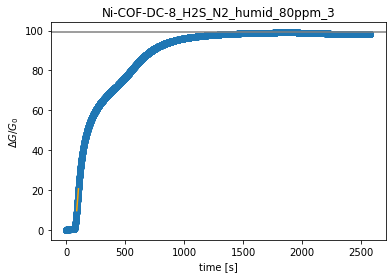

Error: replicate_id 4 does not exist in the data.


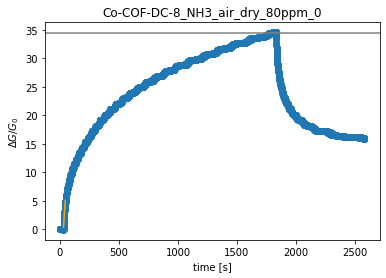

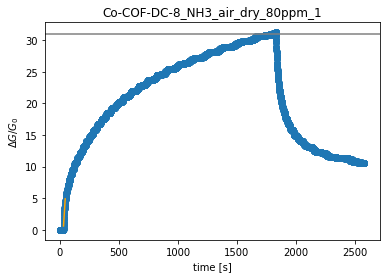

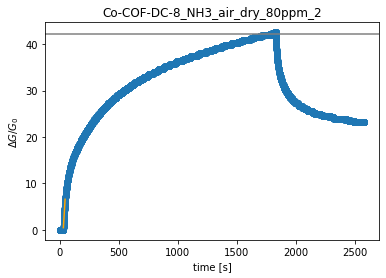

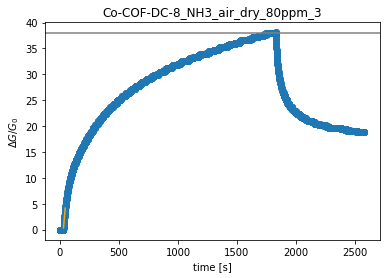

Error: replicate_id 4 does not exist in the data.


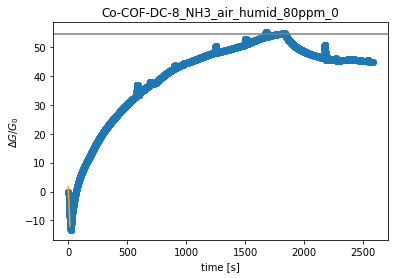

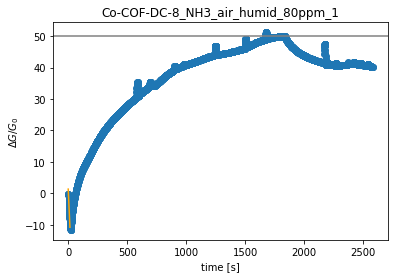

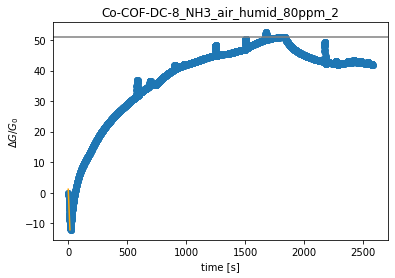

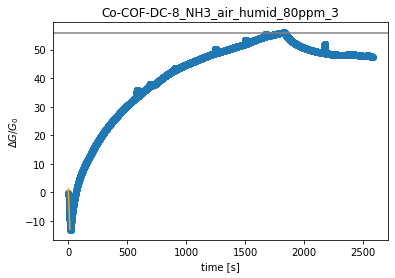

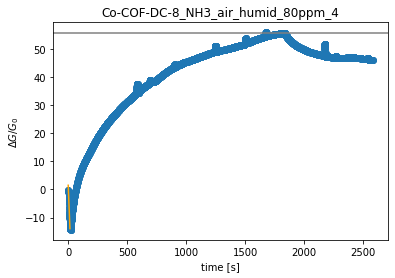

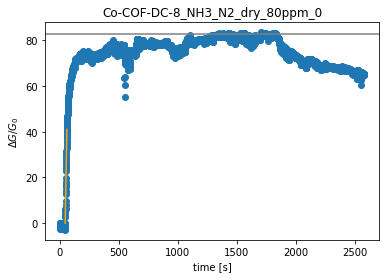

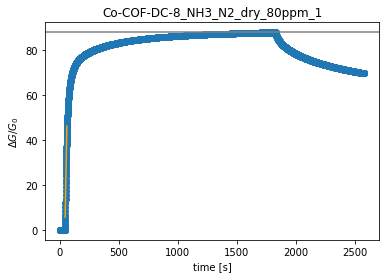

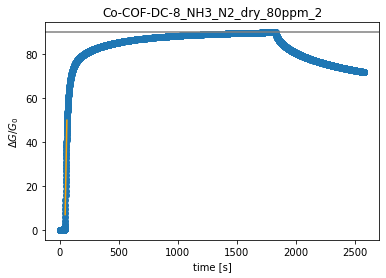

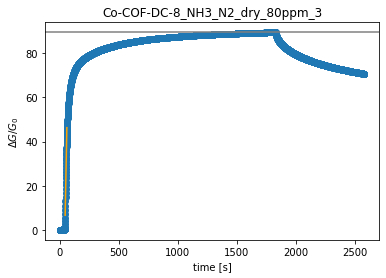

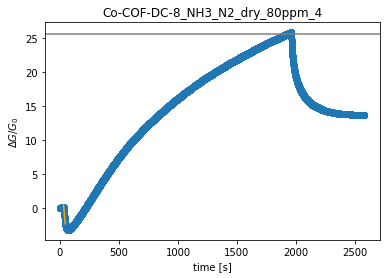

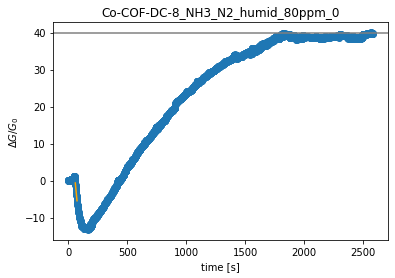

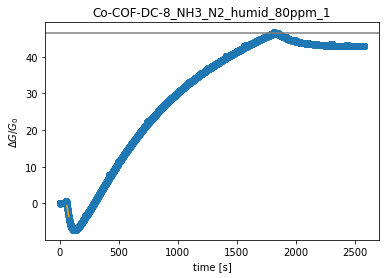

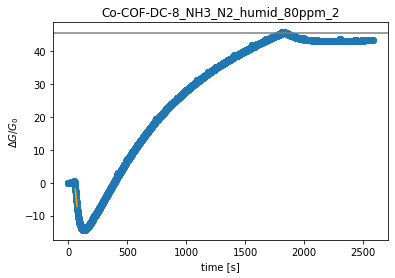

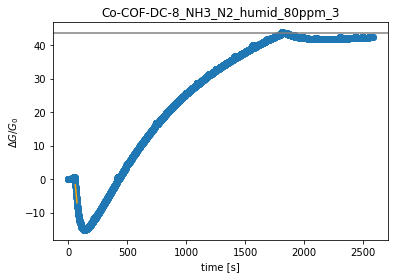

Error: replicate_id 4 does not exist in the data.


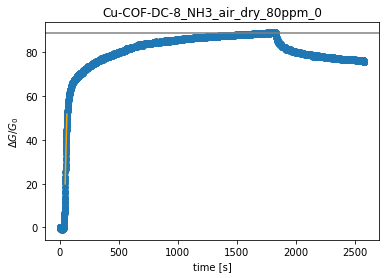

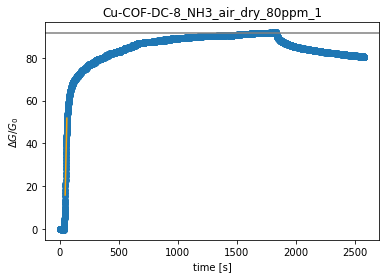

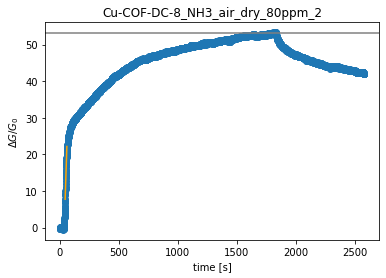

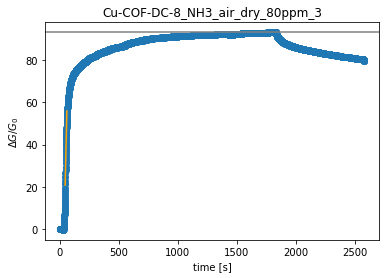

Error: replicate_id 4 does not exist in the data.


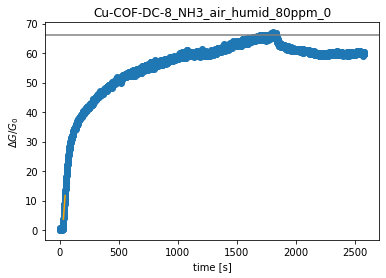

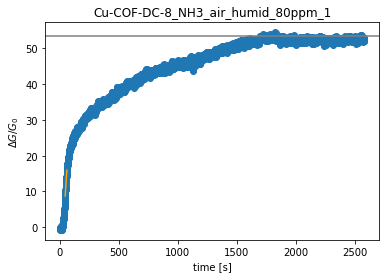

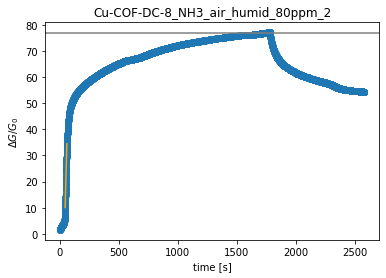

Error: replicate_id 3 does not exist in the data.


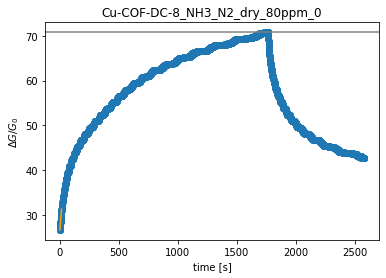

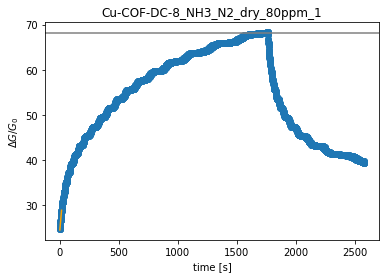

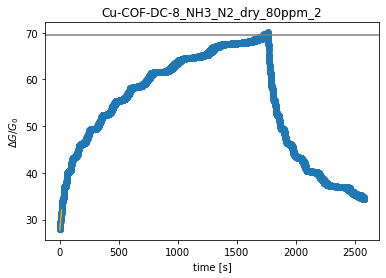

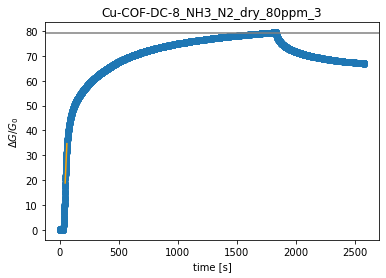

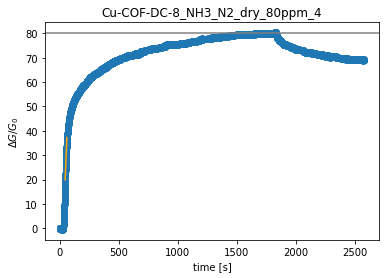

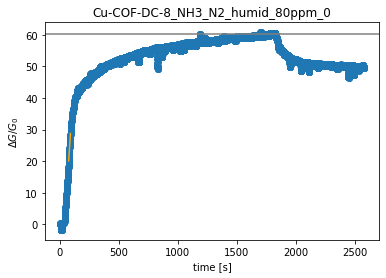

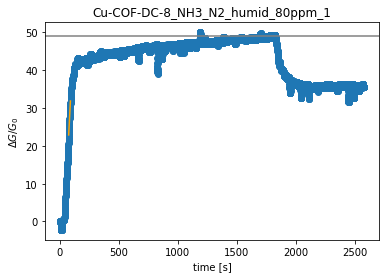

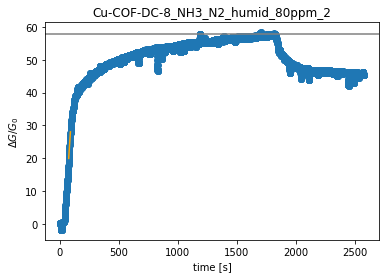

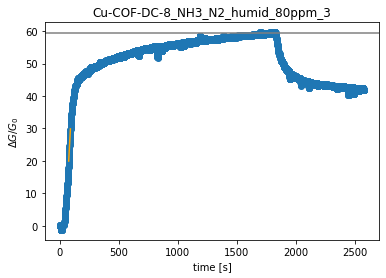

Error: replicate_id 4 does not exist in the data.
Error: replicate_id 0 does not exist in the data.
Error: replicate_id 0 does not exist in the data.


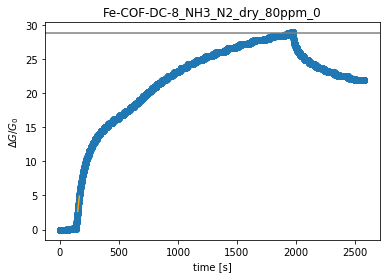

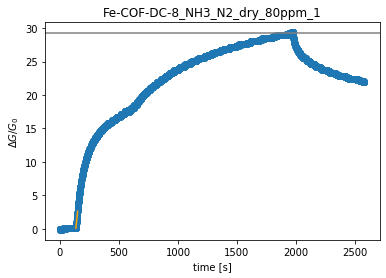

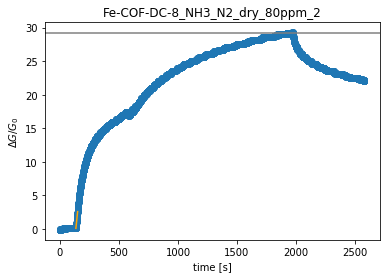

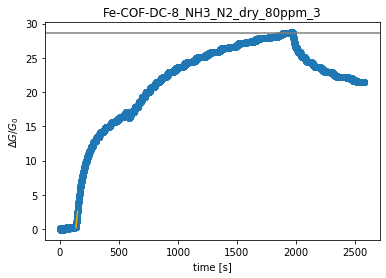

Error: replicate_id 4 does not exist in the data.
Error: replicate_id 0 does not exist in the data.


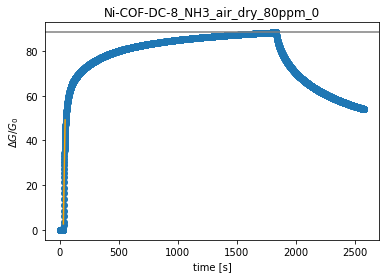

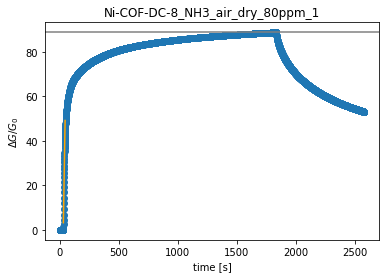

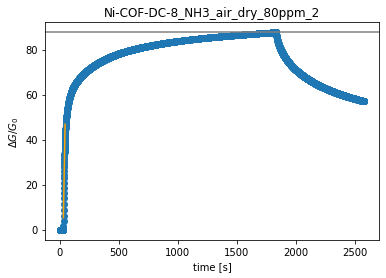

Error: replicate_id 3 does not exist in the data.


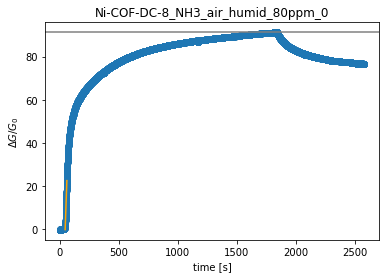

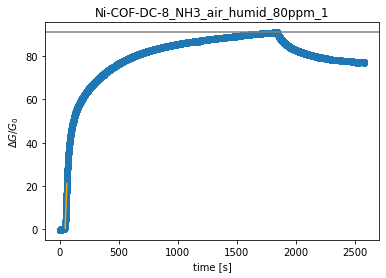

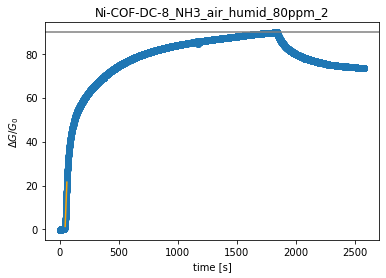

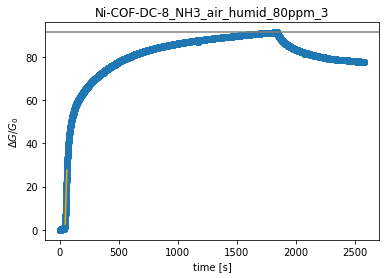

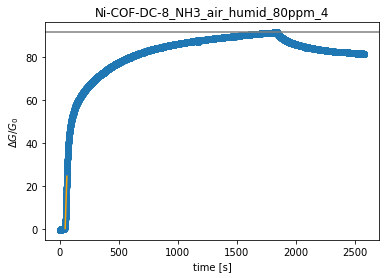

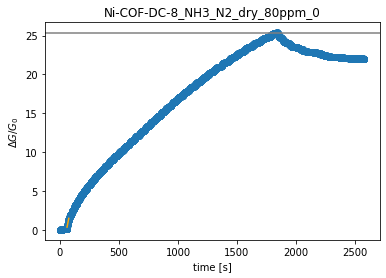

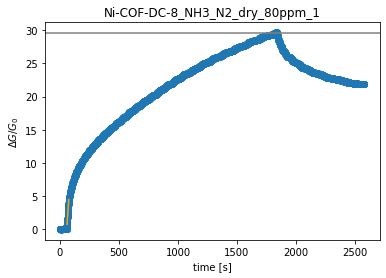

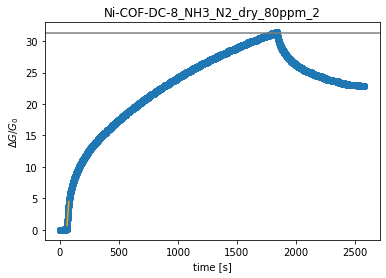

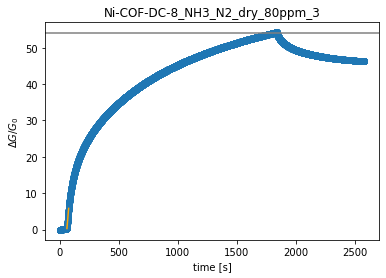

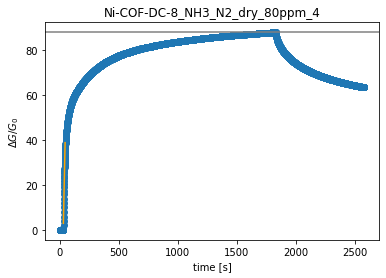

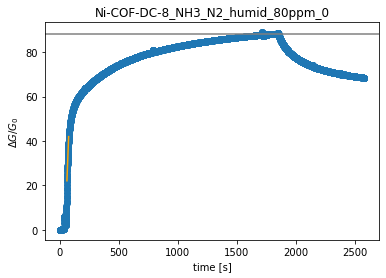

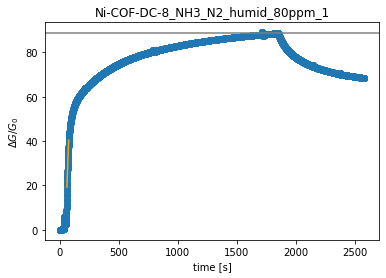

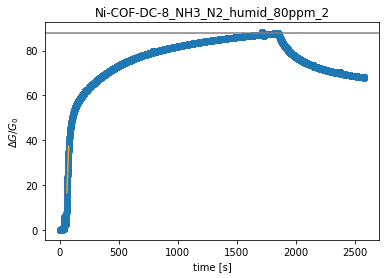

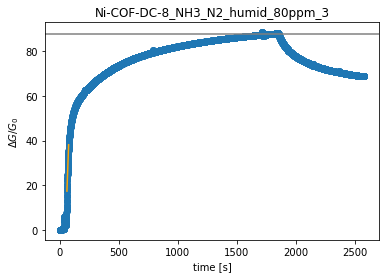

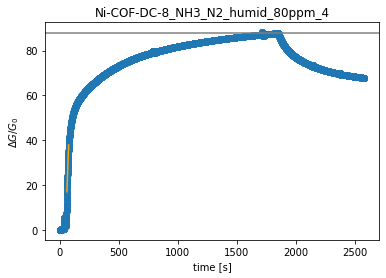

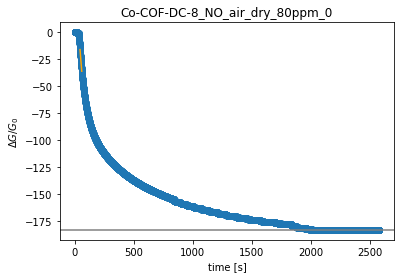

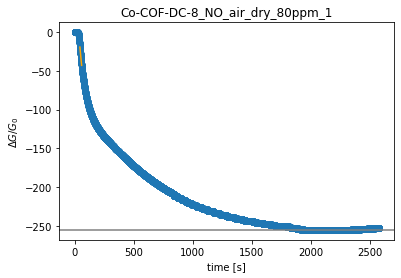

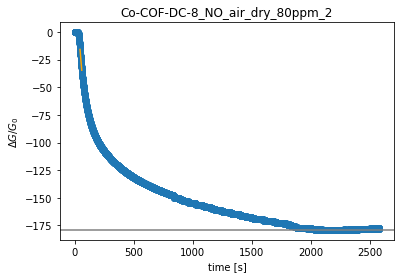

Error: replicate_id 3 does not exist in the data.


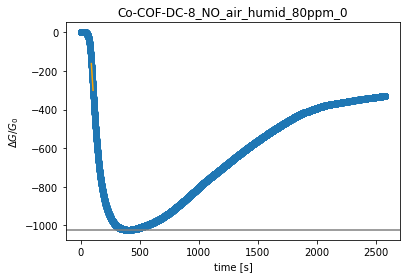

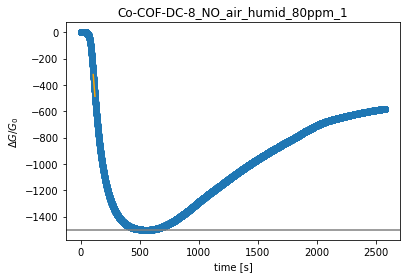

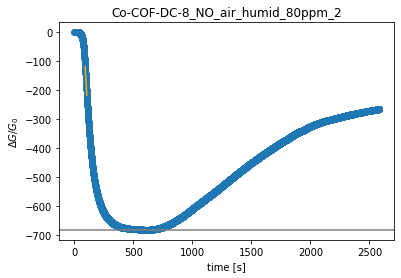

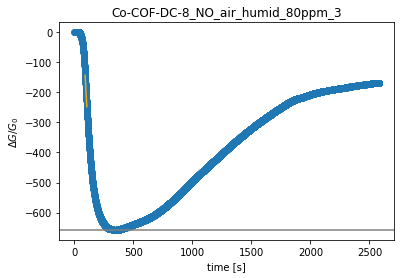

Error: replicate_id 4 does not exist in the data.


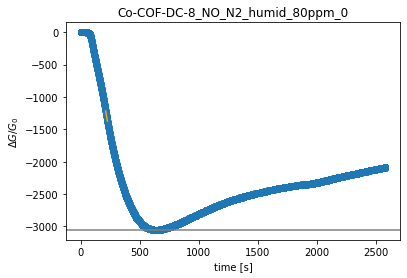

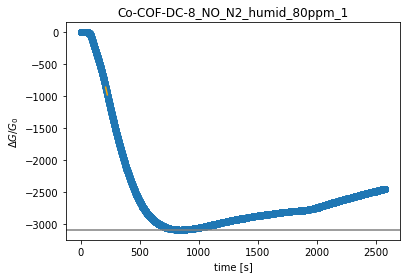

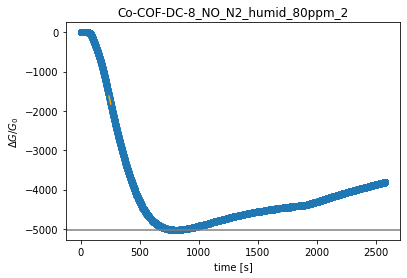

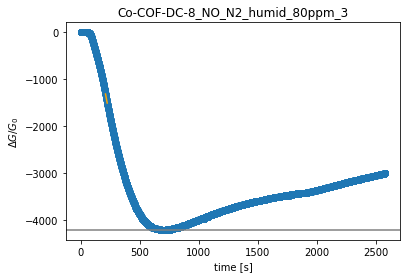

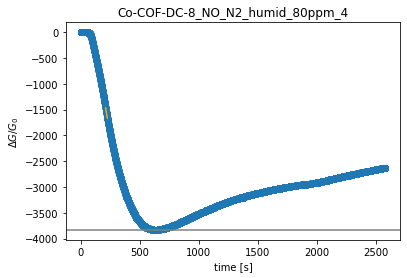

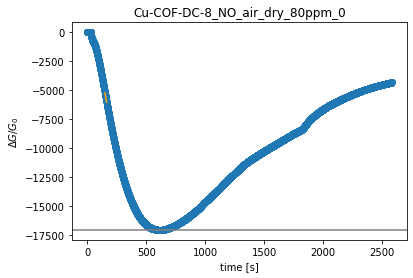

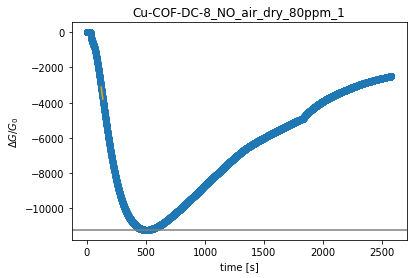

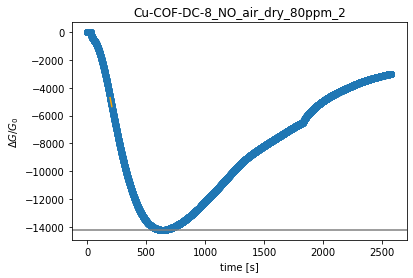

Error: replicate_id 3 does not exist in the data.


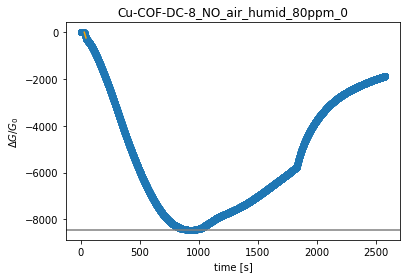

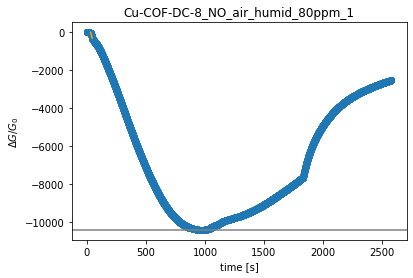

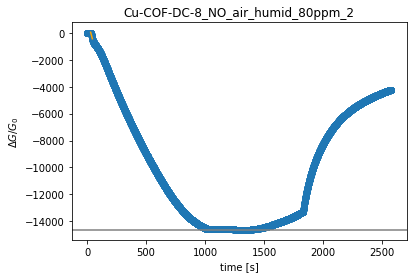

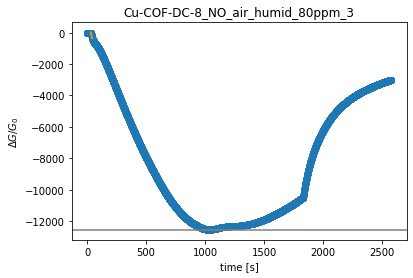

Error: replicate_id 4 does not exist in the data.


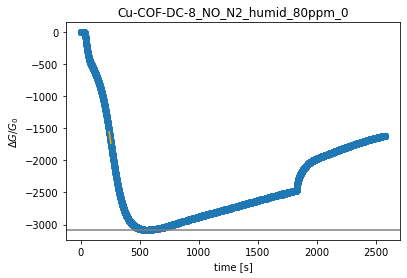

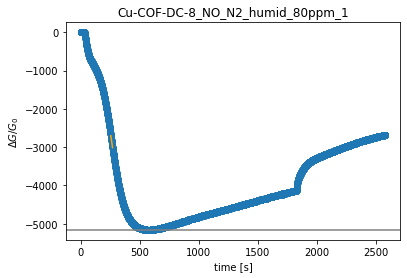

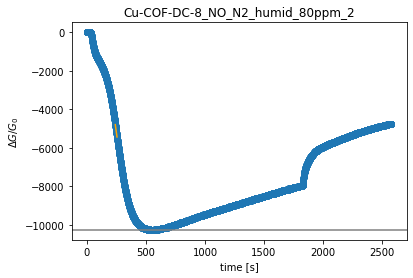

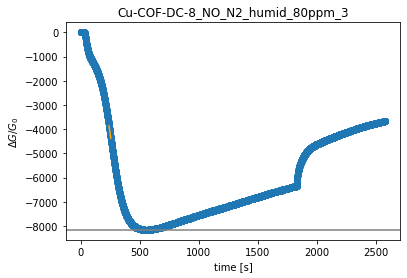

Error: replicate_id 4 does not exist in the data.
Error: replicate_id 0 does not exist in the data.
Error: replicate_id 0 does not exist in the data.
Error: replicate_id 0 does not exist in the data.


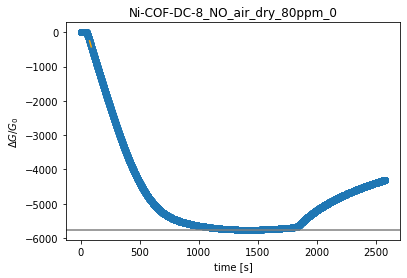

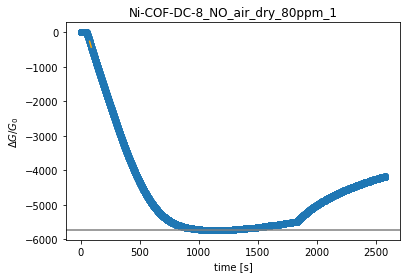

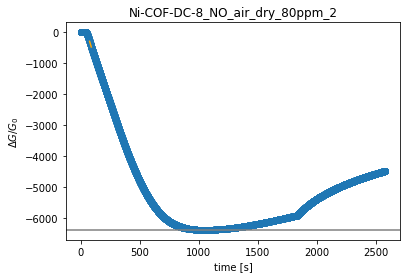

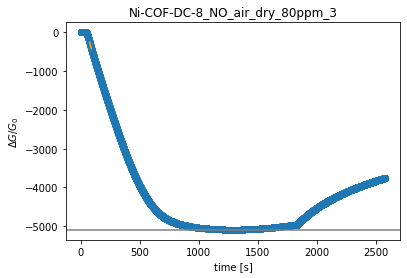

Error: replicate_id 4 does not exist in the data.


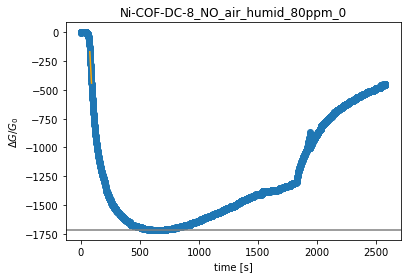

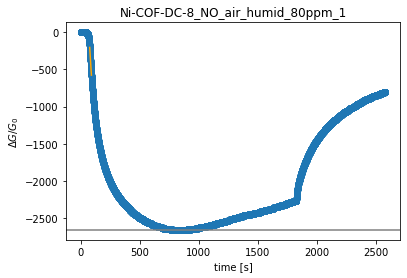

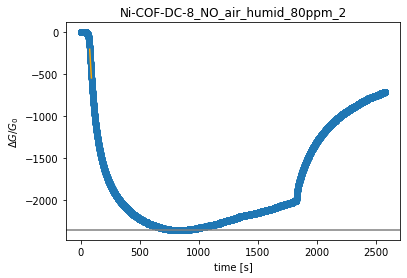

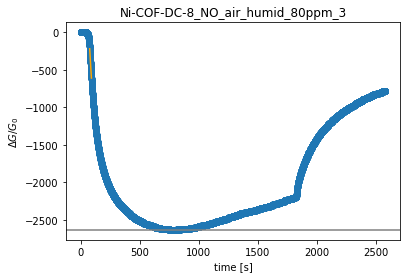

Error: replicate_id 4 does not exist in the data.


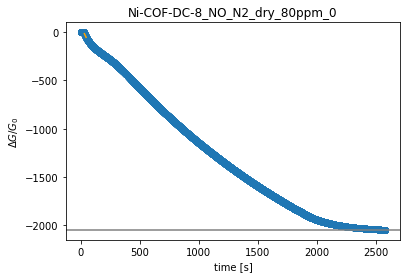

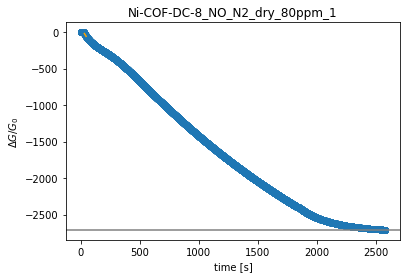

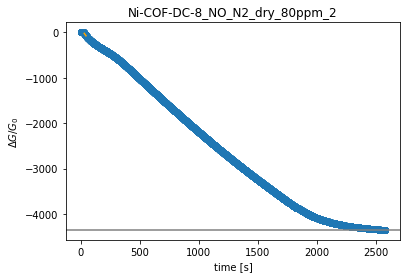

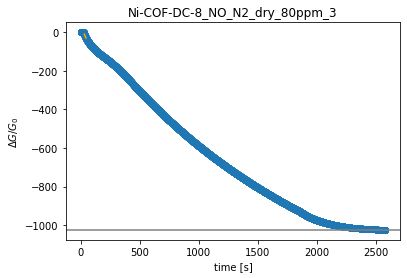

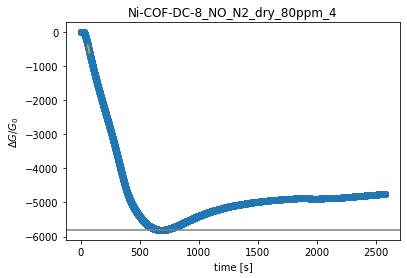

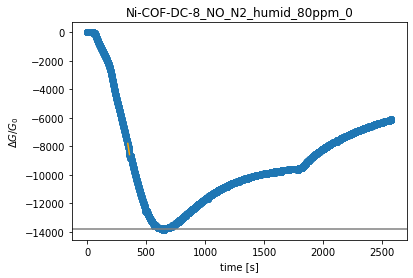

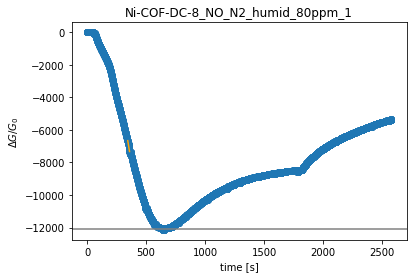

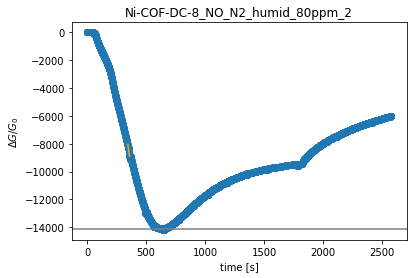

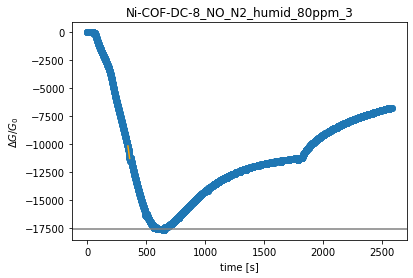

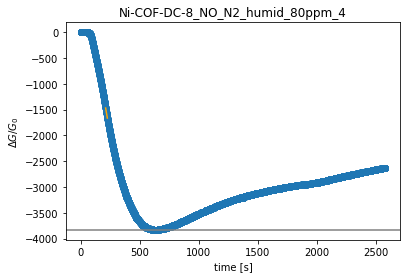

In [12]:
gases = ['CO', 'H2S', 'NH3', 'NO']
cofs = ['Co-COF-DC-8', 'Cu-COF-DC-8', 'Fe-COF-DC-8', 'Ni-COF-DC-8']
air_conds = ['air_dry', 'air_humid', 'N2_dry', 'N2_humid']

for gas in gases:
    for cof in cofs:
        for air in air_conds:
            for rep_id in range(5):
                try:
                    sensor_response = SensorResponse(cof, gas, air, 80, rep_id)
                    sensor_response.compute_features()
                    sensor_response.viz(save=True)
                except (AttributeError, Exception):
                    break
                